### Summary of Chapter 1 - 4 of Book "Learning Large Language Models From Scratch (by Sebastian Raschka)"

In [1]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 256, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

In [2]:
# ch 1 & 2
import urllib.request
import torch
import tiktoken  
from torch.utils.data import Dataset, DataLoader

# Download the text file
url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

# Load and tokenize the text
with open(r"C:\Users\ashmi\Documents\Artificial Intelligence\Deep Learning\Pytorch\Learning Codes\Deep learning\PRACTICE\Transformer\mama_project\input.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

tokenizer = tiktoken.get_encoding("cl100k_base")  
enc_text = tokenizer.encode(raw_text)

# Define a custom dataset class
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# Function to create a DataLoader
def create_dataloader_v1(txt, batch_size, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader 

# Create DataLoader
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=2, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
second_batch = next(data_iter)
print("First batch:", first_batch)
print("Second batch:", second_batch)

# --- Adding Token and Positional Embeddings ---

# Define token embedding layer
vocab_size = 50257  # Typical size for GPT models
embedding_dim = 256  # Example embedding size (GPT-3 uses 12,288)
token_embedding_layer = torch.nn.Embedding(vocab_size, embedding_dim)

# Convert token IDs into token embeddings
token_embeddings = token_embedding_layer(first_batch[0])  # First batch of inputs
print("Token Embeddings Shape:", token_embeddings.shape)

# Define positional embedding layer
max_length = 4  # Same as the max sequence length
pos_embedding_layer = torch.nn.Embedding(max_length, embedding_dim)

# Generate position embeddings
positions = torch.arange(max_length).unsqueeze(0)  # Create position indices
pos_embeddings = pos_embedding_layer(positions)
print("Positional Embeddings Shape:", pos_embeddings.shape)

# Combine token and positional embeddings
input_embeddings = token_embeddings + pos_embeddings
print("Final Input Embeddings Shape:", input_embeddings.shape)

First batch: [tensor([[ 5962, 22307,    25,   198]]), tensor([[22307,    25,   198,  8421]])]
Second batch: [tensor([[  25,  198, 8421,  356]]), tensor([[ 198, 8421,  356, 5120]])]
Token Embeddings Shape: torch.Size([1, 4, 256])
Positional Embeddings Shape: torch.Size([1, 4, 256])
Final Input Embeddings Shape: torch.Size([1, 4, 256])


In [3]:
# ch 3
import torch.nn as nn # type: ignore
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,context_length , dropout, num_heads, qkv_bias = False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads 
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask' , torch.triu(torch.ones(context_length, context_length), diagonal=1))
    def forward(self , x):
        b, num_tokens,d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(b, num_tokens,self.num_heads,self.head_dim)
        values = values.view(b, num_tokens,self.num_heads,self.head_dim)
        queries = queries.view(b, num_tokens,self.num_heads,self.head_dim)
        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)
        attn_scores = queries @ keys.transpose(-2,-1)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # Correct method call
        return context_vec


In [5]:
# ch 4

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self,x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True)
        norm_x=(x-mean)/ torch.sqrt(var+self.eps)
        return norm_x*self.scale+self.shift
class GELU(nn.Module):
    def forward(self,x):
        return 0.5*0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *(x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self,x):
        return self.layers(x)
class ShortcutConnection(nn.Module):
    def __init__(self,layer_size,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_size[0] , layer_size[1]),
                         GELU() ),
             nn.Sequential(nn.Linear(layer_size[0] , layer_size[1]),
                         GELU() ),
             nn.Sequential(nn.Linear(layer_size[0] , layer_size[1]),
                         GELU() ),
             nn.Sequential(nn.Linear(layer_size[0] , layer_size[1]),
                         GELU() ),
        ])
    def forward(self,x):
            for layer in self.layers:
                layer_output = layer(x)
                if self.use_shortcut and x.shape == layer_output.shape:
                    x = x + layer_output
                else:
                    x = layer_output
            return x

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
             d_in=cfg["emb_dim"],
             d_out=cfg["emb_dim"],
             context_length=cfg["context_length"],
             num_heads=cfg["n_heads"],
             dropout=cfg["drop_rate"],
             qkv_bias=cfg["qkv_bias"] 
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self,x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embds = self.tok_emb(in_idx)
        pos_embds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x= tok_embds + pos_embds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits= self.out_head(x)
        return logits

In [6]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        # Adjust context size to match the available tokens
        start_idx = max(0, idx.size(1) - context_size)
        idx_cond = idx[:, start_idx:]
        
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]  # Get logits for the last token in context
        probas = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # Get the next token
        
        idx = torch.cat((idx, idx_next), dim=1)  # Append the next token to the sequence
    return idx

In [7]:
import tiktoken  # type: ignore
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [8]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.3877,  0.4158, -0.5787,  ...,  0.1276, -0.5383,  0.2446],
         [-0.2554, -0.1288, -0.7926,  ...,  0.3047, -1.1738,  0.3123],
         [ 0.7388, -0.1012, -0.4025,  ...,  0.4566, -0.5240,  0.2286],
         [-0.0734, -0.7353, -1.0307,  ...,  0.3615,  0.3656, -0.1678]],

        [[-0.1286,  0.2205, -0.9525,  ..., -0.1467, -0.7149, -0.0383],
         [-0.6371, -0.4865, -0.9413,  ...,  0.2877, -0.2713,  0.2986],
         [ 0.3656,  0.0895,  0.2042,  ...,  0.0988,  0.2296, -0.1554],
         [-0.2582, -0.1317, -0.5016,  ..., -0.1865, -0.0638, -0.3825]]],
       grad_fn=<UnsafeViewBackward0>)


Here are the phases shown in the text and their summaries:

Phase 1 - Model Setup
- Initialize GPT model with GPT_CONFIG_124M configuration
- Reduce context length to 256 tokens
- Set model to evaluation mode

Phase 2 - Text Generation Pipeline
- Convert input text to token IDs
- Process token IDs through model to get logits 
- Convert logits back to text via token IDs

The text ends before showing the implementation of Phase 2, indicating there would be code in the following listing.

In [10]:
import tiktoken
import torch

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

# Initialize tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Generate text
start_context = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

# Print generated text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you renting torch Dur extravagant Vaughn imprisoned conqu Burn plasticsfigured


Alright, let's break this down step by step in simple terms without skipping any important details.

### What is being discussed?

This is about evaluating how well a text-generation model (like GPT) works during training by measuring **loss**—a number that tells us how far the model's generated text is from what we want it to generate. This is part of the process of teaching the model to improve its predictions. 

---

### 1. **Loading Data and Text Generation Process**
We start with input examples, like sentences, which are first broken into tokens (small pieces of text like words or characters). Each token is converted to a number (called a token ID) using a **vocabulary**—a dictionary that maps text to numbers.

#### Example:
- Input sentences: `"every effort moves"` and `"I really like"`
- Token IDs:  
  ```python
  inputs = torch.tensor([
      [16833, 3626, 6100],  # "every effort moves"
      [40, 1107, 588]       # "I really like"
  ])
  ```

The target tokens are the **next words** in the sentences, shifted one step forward:
- Targets:  
  ```python
  targets = torch.tensor([
      [3626, 6100, 345],   # "effort moves you"
      [1107, 588, 11311]   # "really like chocolate"
  ])
  ```

---

### 2. **How the Model Generates Text**
The process involves the following steps (illustrated in **Figure 5.4**):

1. **Map input text to token IDs**: Use the vocabulary to turn words into numbers.
2. **Generate probability scores**: The model predicts how likely each word in its vocabulary is to come next in the sentence. For example:
   - For the token `"every"`, it might predict:
     ```python
     [0.10, 0.60, 0.20, 0.05, 0.00, 0.02, 0.01]
     ```
     This is a probability distribution over all words in the vocabulary.
3. **Pick the most likely token**: Use `argmax` to find the token with the highest probability (e.g., `"effort"` if its probability is 0.60).
4. **Convert back to text**: Map the selected token IDs back into words using an **inverse vocabulary**.

---

### 3. **Why Does the Model Generate Random Text Initially?**
When the model hasn’t been trained yet, it produces random text because it doesn’t "know" what comes next. For example:
- Input: `"every effort moves"`
- Target: `"effort moves you"`
- Output (from the untrained model): `"Armed heNetflix"`

This happens because the model's weights (parameters) are still random, leading to random predictions.

---

### 4. **Evaluating the Model with Loss**
To measure how "wrong" the model's predictions are, we calculate the **loss**:
1. Feed the inputs into the model, which generates **logits**—raw scores for each token in the vocabulary.
2. Apply a **softmax function** to convert logits into probabilities (numbers between 0 and 1 that add up to 1).
   - Example probabilities for three tokens in a sentence:
     ```python
     [[0.00007, 0.00003, 0.00001],  # probabilities for "effort"
      [0.00001, 0.00005, 0.000004], # probabilities for "moves"
      ...]                          # and so on
     ```

3. Use the **argmax function** to find the token with the highest probability.

---

### 5. **Comparing Predictions to Targets**
The key idea is to check how close the model's predicted probabilities are to the correct tokens. For example:
- Target token: `"effort"`
- Probability assigned by the model: `0.00007` (very low since the model is untrained).

If the model assigns a low probability to the correct token, it means the loss is high, and the model needs improvement.

---

### 6. **What Does Training Do?**
During training, we adjust the model's weights so that it assigns **higher probabilities to the correct tokens**. The goal is to maximize the probability of the correct token and minimize the loss. Over time:
- Before training: `"effort"` → Probability: `0.00007`
- After training: `"effort"` → Probability: `0.7` (much better!)

---

### Why This Matters
By calculating loss and updating the model's weights, we ensure that the generated text becomes more accurate and resembles human-like writing. This loss calculation is not just for evaluating the model but also a critical part of improving it.

---

### Summary
- Input sentences are turned into token IDs using a vocabulary.
- The model predicts probabilities for the next token in the sequence.
- The loss measures how far the predictions are from the correct targets.
- Training adjusts the model so it assigns higher probabilities to the correct tokens.
- Over time, the model improves, generating text that makes sense and aligns with human expectations.

### Summarizing Backpropagation, Cross-Entropy Loss, and Perplexity

#### **Backpropagation**
The goal of backpropagation is to adjust model weights to maximize the softmax probabilities for the target tokens (the correct next words). This process involves:  
1. **Calculating Loss**: The loss function quantifies the difference between the model’s predictions and the target tokens.  
2. **Updating Weights**: The model adjusts its internal parameters to reduce this loss, improving the likelihood of predicting correct tokens.  

Backpropagation requires the following steps:
1. **Logits to Probabilities**: Convert raw model outputs (logits) into probabilities using the softmax function.
2. **Log Probabilities**: Use logarithms of probabilities for better numerical stability.
3. **Negative Average Log Probability**: Compute the mean of these log probabilities (negative for minimization) to evaluate the model's performance.

For example, if the **average log probability** of the target tokens is `-10.7940`, the **negative average log probability (loss)** becomes `10.7940`. This loss value is the cross-entropy loss, a standard metric in deep learning.

---

#### **Cross-Entropy Loss**
Cross-entropy loss measures the difference between:
- The true distribution of target tokens.
- The predicted token probability distribution.

**Steps to Compute Cross-Entropy Loss**:
1. Flatten the tensors (combine batch and sequence dimensions):
   - Logits: `torch.Size([6, 50257])` (6 tokens, 50,257 vocabulary size).
   - Targets: `torch.Size([6])` (6 token IDs).
2. Use PyTorch's `cross_entropy` function:
   ```python
   loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
   ```
   This automates the process of:
   - Applying softmax to logits.
   - Selecting probabilities for the target tokens.
   - Computing the negative average log probability.

The result (e.g., `loss = 10.7940`) matches manually calculated values.

---

#### **Perplexity**
Perplexity translates the model's loss into an interpretable measure of uncertainty. It reflects the effective vocabulary size over which the model is uncertain when predicting the next token.  
- Formula:  
  ```python
  perplexity = torch.exp(loss)
  ```  
  Example: If `loss = 10.7940`, the perplexity is `exp(10.7940) ≈ 48,725`, meaning the model struggles to confidently select the correct word out of ~48,725 options.

#### **Key Takeaways**
1. Cross-entropy loss quantifies how far the model’s predictions are from the target distribution.
2. Backpropagation minimizes this loss by updating model weights.
3. Perplexity offers an interpretable metric to evaluate model uncertainty—lower values indicate better performance.

In [11]:
file_path = "the-verdict.txt"
with open(file_path, "r") as file:
    text_data = file.read()
    

In [12]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [13]:
train_ratio= 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data  = text_data[split_idx:]


In [14]:
train_loader = create_dataloader_v1(
train_data,
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=True,
shuffle=True,
num_workers=0
)
val_loader = create_dataloader_v1(
val_data,
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=False,
shuffle=False,
num_workers=0
)

In [15]:
print ("Train Loader ")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)  

Train Loader 
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [16]:
def analyze_dimensions(train_loader, val_loader, tokenizer, text_data):
    # Analyze text data
    total_chars = len(text_data)
    total_tokens = len(tokenizer.encode(text_data))
    
    # Analyze training loader
    train_batches = len(train_loader)
    train_sequences = train_batches * 2  # since batch_size=2
    train_tokens = train_sequences * 256  # since each sequence has 256 tokens
    
    # Analyze validation loader
    val_batches = len(val_loader)
    val_sequences = val_batches * 2
    val_tokens = val_sequences * 256
    
    print("=== Overall Data Dimensions ===")
    print(f"Total characters in text: {total_chars:,}")
    print(f"Total tokens in text: {total_tokens:,}")
    print("\n=== Training Data Dimensions ===")
    print(f"Number of batches: {train_batches}")
    print(f"Number of sequences: {train_sequences}")
    print(f"Tokens per sequence: 256")
    print(f"Total tokens processed per epoch: {train_tokens:,}")
    print("\n=== Single Training Batch Structure ===")
    print("Shape: [2, 256]")
    print("  - 2: number of sequences per batch")
    print("  - 256: tokens per sequence")
    print(f"Total tokens per batch: {2 * 256}")
    print("\n=== Validation Data Dimensions ===")
    print(f"Number of batches: {val_batches}")
    print(f"Number of sequences: {val_sequences}")
    print(f"Tokens per sequence: 256")
    print(f"Total tokens: {val_tokens:,}")

# Use the function
analyze_dimensions(train_loader, val_loader, tokenizer, text_data)

=== Overall Data Dimensions ===
Total characters in text: 20,479
Total tokens in text: 5,145

=== Training Data Dimensions ===
Number of batches: 9
Number of sequences: 18
Tokens per sequence: 256
Total tokens processed per epoch: 4,608

=== Single Training Batch Structure ===
Shape: [2, 256]
  - 2: number of sequences per batch
  - 256: tokens per sequence
Total tokens per batch: 512

=== Validation Data Dimensions ===
Number of batches: 1
Number of sequences: 2
Tokens per sequence: 256
Total tokens: 512


In [17]:
def calc_loss_batch(input_batch , target_batch, model, device, num_batches= None):
    input_batch = input_batch.to(device)
    target_batch= target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss
        

In [18]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
   
    # Return NaN if the data loader is empty
    if len(data_loader) == 0:
        return float("nan")

    # Use all batches if num_batches is not specified, otherwise use the minimum
    num_batches = len(data_loader) if num_batches is None else min(num_batches, len(data_loader))

    total_loss = 0.0

    # Iterate through the data loader and compute loss
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break

        # Calculate loss for the current batch
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()

    # Return the average loss
    return total_loss / num_batches


I'll explain the code again, using a specific example for an LLM (Large Language Model) like GPT. Imagine we're training it to complete sentences.

```python
def calc_loss_loader(data_loader, model, device, num_batches=None):
```
- This function takes in:
  - `data_loader`: Contains batches of text data
    Example: Batches of sentences like ["The cat sat on the", "The dog chased the"]
  - `model`: Your LLM
  - `device`: CPU or GPU for processing
  - `num_batches`: Optional number of batches to process

```python
if len(data_loader) == 0:
    return float("nan")
```
- If your data loader is empty (no sentences to process), return NaN
- Example: If someone gave you an empty text file to train on

```python
num_batches = len(data_loader) if num_batches is None else min(num_batches, len(data_loader))
```
- If `num_batches` isn't specified:
  Example: You have 1000 batches of sentences, uses all 1000
- If specified:
  Example: You have 1000 batches but set num_batches=100, it uses 100 batches

```python
total_loss = 0.0
```
- Starts tracking total error at 0
- This will add up how wrong the model's predictions are

```python
for i, (input_batch, target_batch) in enumerate(data_loader):
```
- Goes through each batch of sentences
- Example batch:
  - `input_batch`: ["The cat sat on the", "The dog chased the"]
  - `target_batch`: ["mat", "ball"]
  - The model should predict "mat" when given "The cat sat on the"

```python
if i >= num_batches:
    break
```
- Stops after processing desired number of batches
- Example: If you set num_batches=100, stops after 100 batches even if there's more data

```python
loss = calc_loss_batch(input_batch, target_batch, model, device)
```
- For each batch, calculates how wrong the model's predictions are
- Example:
  - Input: "The cat sat on the"
  - Target: "mat"
  - Model's prediction: "hat"
  - This would give a high loss because "hat" ≠ "mat"

```python
total_loss += loss.item()
```
- Adds up the errors from each batch
- Example:
  - Batch 1 loss: 2.3 (model was quite wrong)
  - Batch 2 loss: 1.5 (model was somewhat wrong)
  - total_loss after these batches: 3.8

```python
return total_loss / num_batches
```
- Calculates average error across all batches
- Example:
  - If total_loss = 380 after 100 batches
  - Returns 380/100 = 3.8 average loss per batch

Real-world example:
Let's say you're training an LLM on a Shakespeare dataset:
- Input: "To be or not to"
- Target: "be"
- If model predicts "exist" instead of "be":
  1. High loss for this prediction
  2. Add this loss to total_loss
  3. After processing many batches of Shakespeare text
  4. Get average loss to see how well model understands Shakespeare's writing style

A lower average loss (like 1.0) means your LLM is getting good at predicting Shakespeare's words
A higher average loss (like 5.0) means it's still making lots of mistakes

This helps you track if your LLM is improving during training. Think of it like a grade that shows how well your model speaks "Shakespeare"!

Let me break down this line even further with clear examples.

This line uses a conditional (ternary) operator to set the value of `num_batches`. Let's split it into the equivalent if-else statement to make it clearer:

```python
if num_batches is None:
    num_batches = len(data_loader)
else:
    num_batches = min(num_batches, len(data_loader))
```

Let's look at three scenarios:

1. When `num_batches` is None (not specified):
```python
data_loader has 1000 batches
num_batches = None
Result: num_batches = 1000 (uses all available batches)
```

2. When `num_batches` is smaller than data_loader length:
```python
data_loader has 1000 batches
num_batches = 100
Result: num_batches = 100 (uses the smaller number)
```

3. When `num_batches` is larger than data_loader length:
```python
data_loader has 1000 batches
num_batches = 1500
Result: num_batches = 1000 (can't use more batches than we have)
```

Think of it like this: You have a box of 1000 cookies (data_loader):
- If someone doesn't specify how many cookies they want (num_batches is None), give them all 1000
- If they ask for 100 cookies, give them 100
- If they ask for 1500 cookies, you can only give them 1000 (because that's all you have)

This line ensures you never try to process more batches than actually exist in your data, while also allowing flexibility in how many batches you want to use for training.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model. to(device)
with torch.no_grad ():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.997887399461534
Validation loss: 10.987743377685547


In [20]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    
    model.train()
    
    return train_loss, val_loss

In [21]:


def generate_and_print_sample(model, tokenizer, device, start_context):
    
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
    
    model.train()


In [20]:
def train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs,
    eval_freq, eval_iter, start_context, tokenizer
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                print(
                    f"Epoch {epoch + 1} (Step {global_step:06d}): "
                    f"Train Loss: {train_loss:.3f}, "
                    f"Validation Loss: {val_loss:.3f}"
                )
                
                generate_and_print_sample(model, tokenizer, device, start_context)
    
    return train_losses, val_losses, track_tokens_seen


In [21]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer =  torch.optim.AdamW(model.parameters(),lr= 0.0004, weight_decay= 0.01)
num_epochs = 100
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5,eval_iter=5,
start_context="Every effort moves you", tokenizer=tokenizer
)

Epoch 1 (Step 000000): Train Loss: 10.082, Validation Loss: 10.161
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the the,,,,,,,,,,,,,,,,,,,
Epoch 1 (Step 000005): Train Loss: 8.158, Validation Loss: 8.393
Every effort moves you, the,, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Epoch 2 (Step 000010): Train Loss: 6.727, Validation Loss: 7.096
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2 (Step 000015): Train Loss: 6.168, Validation Loss: 6.648
Every effort moves you, the                                                
Epoch 3 (Step 000020): Train Loss: 5.920, Validation Loss: 6.569
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 3 (Step 000025): Train Loss: 5.782, Validation Loss: 6.606
Every effort moves you the the, the the the the the the the the the the the the the the, the 

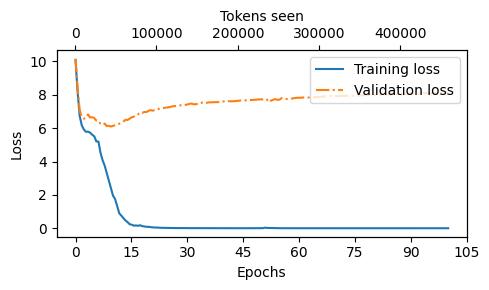

In [23]:
import matplotlib .pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses , val_losses):
    fig, ax1= plt.subplots(figsize = (5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


In [20]:
# First, let's make sure we have all the prerequisites
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = tiktoken.get_encoding("gpt2")

# Some example starting contexts
start_contexts = [
    "He is Laughing at you"
]

# Generate text for each starting context
print("Generating text samples:")
print("-" * 50)

for context in start_contexts:
    print(f"\nStarting context: '{context}'")
    generate_and_print_sample(model, tokenizer, device, context)

Generating text samples:
--------------------------------------------------

Starting context: 'He is Laughing at you'
He is Laughing at you allyHigiability intoxerson ClevelandToo Example dependent TTViol Refer Santanaitters402 synapticprovidedpakalore Allied hiredcasters Situationdecl sacred ensuing kept Voter yesarchivepred Apflush suppliers Tata 23Tank Correction guaranteeingidden iPad008 discover caching continued Homeland Rush succession Eg115


## Decoding strategies to control randomness

forward
toward


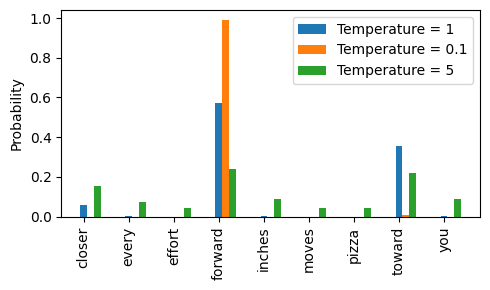

In [21]:
import torch
import matplotlib.pyplot as plt

# Define vocabulary
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

# Create inverse vocabulary for lookups
inverse_vocab = {v: k for k, v in vocab.items()}

# Example logits for next token prediction
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

# Traditional approach using argmax
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

# Probabilistic sampling approach
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

# Function to print distribution of sampled tokens
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
             for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

# Temperature scaling implementation
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Visualization of different temperature effects
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                for T in temperatures]

# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))

for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

Let me explain these three text generation techniques in a way that builds understanding from the ground up.

The three techniques used for generating text in large language models are:
1. Greedy Decoding
2. Temperature Scaling 
3. Top-k Sampling

Let's imagine you're building a language model that's trying to complete the sentence "The cat sat on the ___."

Greedy Decoding:
This is the simplest approach. The model calculates probabilities for every possible next word. Perhaps it calculates that "mat" has 60% probability, "chair" has 30%, and "windowsill" has 10%. Greedy decoding simply picks the highest probability - "mat" - every single time. It's like a student who always picks the first answer that seems right without considering alternatives. This makes the output very predictable and sometimes repetitive, though usually grammatically correct.

Temperature Scaling:
This technique introduces controlled randomness. Going back to our example, instead of always picking "mat," we adjust how "decisive" the model is. The temperature is like a confidence dial:

At low temperature (like 0.1):
- The 60% probability for "mat" becomes more like 95%
- The 30% for "chair" shrinks to maybe 4%
- The 10% for "windowsill" becomes nearly 1%
The model becomes very conservative, almost always picking "mat."

At high temperature (like 5.0):
- The 60% might become 40%
- The 30% might become 35%
- The 10% might become 25%
Now the model might more readily pick "chair" or even "windowsill," leading to more diverse but potentially less reliable outputs.

Top-k Sampling:
This technique addresses a key problem with temperature scaling: sometimes it makes the model consider truly inappropriate words. With Top-k sampling, we first select the k most likely words (let's say k=3), and only then apply our probability calculations to those options. 

In our example, if k=3:
1. First, we identify the three most probable words: "mat," "chair," "windowsill"
2. We completely eliminate all other possibilities (like "pizza" or "elephant")
3. Then we can apply temperature scaling just to these three choices

This gives us the best of both worlds - we maintain some creative variety in our outputs while preventing completely nonsensical choices.

To understand how these work together: Greedy decoding is like always ordering the most popular dish at a restaurant. Temperature scaling is like how adventurous you're feeling when ordering. Top-k sampling is like limiting your choices to just the chef's specials before deciding how adventurous to be.

In practice, modern language models often combine temperature scaling with top-k sampling. They first limit the vocabulary to the k most likely choices, then apply temperature scaling to those choices to control how random versus predictable the output should be. This produces text that can be creative when needed while staying reasonably coherent.

Would you like me to elaborate on any of these aspects or provide more examples of how they work in practice?

In [22]:
import torch

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None, device='cuda'):
    """
    Generates text using a language model.
    
    Args:
        model: The language model.
        idx: The initial token indices (tensor of shape [batch_size, sequence_length]).
        max_new_tokens: Maximum number of tokens to generate.
        context_size: Context length to consider.
        temperature: Sampling temperature (higher values = more randomness).
        top_k: Number of top logits to consider for sampling.
        eos_id: End-of-sequence token ID.
        device: Device to run the generation on ('cuda' or 'cpu').
    
    Returns:
        A tensor containing the generated token indices.
    """
    idx = idx.to(device)
    model.to(device)
    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
            logits = logits[:, -1, :]  # Focus on the last time step
        
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf'), device=logits.device),
                logits
            )
        
        if temperature > 0.0:
            logits /= temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if eos_id is not None and (idx_next == eos_id).any():
            break
        
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

# Example usage:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4,
    device='cuda'
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you thoughtful HTTPS ropesisma suggestfly Abortion sheer Intellectual 124 paragraphsacha endorsed fraud meteor


## Loading and saving model weights in PyTorch

In [23]:
torch.save(model.state_dict(), "GPT_Book.pth")

Let me break this down into simpler terms. This text is explaining a few important concepts about training and saving neural networks, specifically:

1. About Dropout:
- Dropout is a technique to prevent overfitting (when a model learns training data too perfectly and performs poorly on new data)
- It works by randomly deactivating some neurons during training
- During actual use (inference), you don't want dropout active, so you use `model.eval()` to turn it off

2. About Saving Models:
- When you save a model that you plan to continue training later, you should save two things:
  - The model's weights/parameters (using `model.state_dict()`)
  - The optimizer's state (using `optimizer.state_dict()`)

3. About the Optimizer (AdamW):
- AdamW is an optimizer that helps train the model
- It keeps track of historical information about each parameter to adjust learning rates
- If you don't save its state and restart training, it loses this history and might:
  - Train less effectively
  - Fail to learn properly
  - Lose its ability to generate good text

4. The Code Examples Show:
- How to save both model and optimizer states to a file:
```python
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, "model_and_optimizer.pth")
```

- How to load them back:
```python
checkpoint = torch.load("model_and_optimizer.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
```

Think of it like saving a video game - you want to save not just your character's current stats (the model), but also all the power-ups and special abilities you've collected (the optimizer state) so you can continue from exactly where you left off.

In [24]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, "model_and_optimizer.pth")

NameError: name 'optimizer' is not defined

In [37]:
checkpoint = torch.load("model_and_optimizer.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [27]:
import os
def train_model_with_checkpoint(
    model, train_loader, val_loader, optimizer, device, num_epochs,
    eval_freq, eval_iter, start_context, tokenizer, checkpoint_path=None
):
    # Move model to the correct device
    model.to(device)

    # Load checkpoint if provided
    if checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print("Loaded checkpoint successfully")
    else:
        print("Starting fresh training")

    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                print(
                    f"Epoch {epoch + 1} (Step {global_step:06d}): "
                    f"Train Loss: {train_loss:.3f}, "
                    f"Validation Loss: {val_loss:.3f}"
                )
                
                generate_and_print_sample(model, tokenizer, device, start_context)
    
    return train_losses, val_losses, track_tokens_seen

In [28]:
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M).to(device)  # Move model to device
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.01)

# Training parameters
num_epochs = 100
train_losses, val_losses, tokens_seen = train_model_with_checkpoint(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
    checkpoint_path="model_and_optimizer.pth"
)


Loaded checkpoint successfully
Epoch 1 (Step 000000): Train Loss: 0.000, Validation Loss: 8.136
Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I


KeyboardInterrupt: 